# Red Wine Quality Data Exploration and Analysis

By Yiyu Li, Andrew Lai, Claudia Szlavy, and Nanjou Olsen

---

## Introduction

For centuries, red wine has been a popular alcoholic beverage enjoyed by people around the world. With the goal of predicting the qualities of red wines from their various chemical properties, we will be using a dataset containing over a thousand red variants of the Portuguese *vinho verde* wine. This dataset contains information on the quality of red wine, on a scale of 1 to 10, and a number of identifying chemical components of the beverage. For instance, the data set contains each wine’s volume of citric acid, a non-volatile acid in wine that plays a role in managing the sourness, pH, aroma, and the perception of sweetness of the wine (Bhattacharjee, pp. 163). Using chemical properties to predict wine quality is important as it allows wineries to make quality wine in the least expensive way, without the need for taste experts (Nuriel et al. pp.2). 

We will be using classification to answer the following predictive question:<br>
***How well can the quality of red wine be predicted by the wine's chemical factors?***

---

## Methods + Analysis

To answer our predictive question, we will perform multiple KNN classifications with `quality` as our target variable, each using a different set of predictor variables:

1. All variables except `quality`
2. `citricAcid` and `alcohol`
3. `aceticAcid` and `alcohol`
4. `tartaricAcid` and `alcohol`

The `k` value for each classification will be determined by performing a 5-fold cross-validation on our training data, analyzing the prediction accuracies for various values of `k`, and choosing the `k` value with the highest mean prediction accuracy:

- For classification #1, `k` values between 1 and 25 were tested
- For classifications #2, #3, and #4, `k` values between 1 and 40 were tested

The training data and `k` values above will be used to create final KNN models for each classification, which will then be used to predict the qualities of each of the wines in our testing data. These predictions will be used to determine the overall accuracies of each of our models.

### Data Load-in + Overview

In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)

set.seed(11)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
id <- "1ATreL7Rdnf0N9_7UlI1tS1mU9WLR2f4h" # google file ID

wine <- read_csv(sprintf("https://docs.google.com/uc?id=%s&export=download", id), col_types = "dddddddddddi") # data from google drive
colnames(wine) <- make.names(colnames(wine)) # removing of spaces from column names
wine <- wine %>%
    rename("tartaricAcid" = fixed.acidity, "aceticAcid" = volatile.acidity, "citricAcid" = citric.acid, "sugar" = residual.sugar,  # renaming of variables
           "freeSO2" = free.sulfur.dioxide, "totalSO2" = total.sulfur.dioxide) %>%
    mutate(quality = cut(quality, breaks = 2, labels = c("Okay", "Good")))
head(wine, n = 15)

tartaricAcid,aceticAcid,citricAcid,sugar,chlorides,freeSO2,totalSO2,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.700,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,Okay
7.8,0.880,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,Okay
7.8,0.760,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,Okay
11.2,0.280,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,Good
7.4,0.700,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,Okay
7.4,0.660,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,Okay
7.9,0.600,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,Okay
7.3,0.650,0.00,1.2,0.065,15,21,0.9946,3.39,0.47,10.0,Good
7.8,0.580,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,Good


##### *Figure 0.1: The wine data set after the columns have been renamed and the quality has been grouped into two categories. "Good" is the better half of the quality, "Okay" is the worse half of the quality.*<br>

For simplicity, the columns in our dataframe were renamed as follows:

- `fixed acidity` → **`tartaricAcid`** = amount of tartaric acid in the wine (g/L)<sup>1</sup>
- `volatile acidity` → **`aceticAcid`** = amount of acetic acid in the wine (g/L)
- `citric acid` → **`citridAcid`** = amount of citric acid in the wine (g/L)
- `residual sugar` → **`sugar`** = amount of sugar remaining in the wine after fermentation (g/L)
- `free sulfur dioxide` → **`freeSO2`** = amount of free form sulphur dioxide in the wine (mg/L)
- `total sulfur dioxide` → **`totalSO2`** = total amount of sulphur dioxide in the wine (mg/L)

The numerical `quality` column was split into two categories, `"Okay"` and `"Good"`, based on the original values in the column. This was a step recommended by the authors of the data set for classifications done using the data set.

- If `quality >= 6`, then it is `"Good"`
- Otherwise, `quality` is `"Okay"`

The rest of the columns were left unchanged:

- `chlorides` = amount of salt in the wine (g/L)
- `density` = density of the wine (g/L)
- `pH` = overall acidity of the wine
- `sulphates` = amount of sulphates in the wine (g/L)
- `alcohol` = alcohol content of the wine (vol. %)

<hr style="border:1px solid gray"> </hr>

<font size = "2.5"> 1: In the scholarly paper that accompanies this data set, the units are listed as *g/dm<sup>3</sup>* and *mg/dm<sup>3</sup>*, which are equivalent to *g/L* and *mg/L*, respectively</font>

#### Density Plot

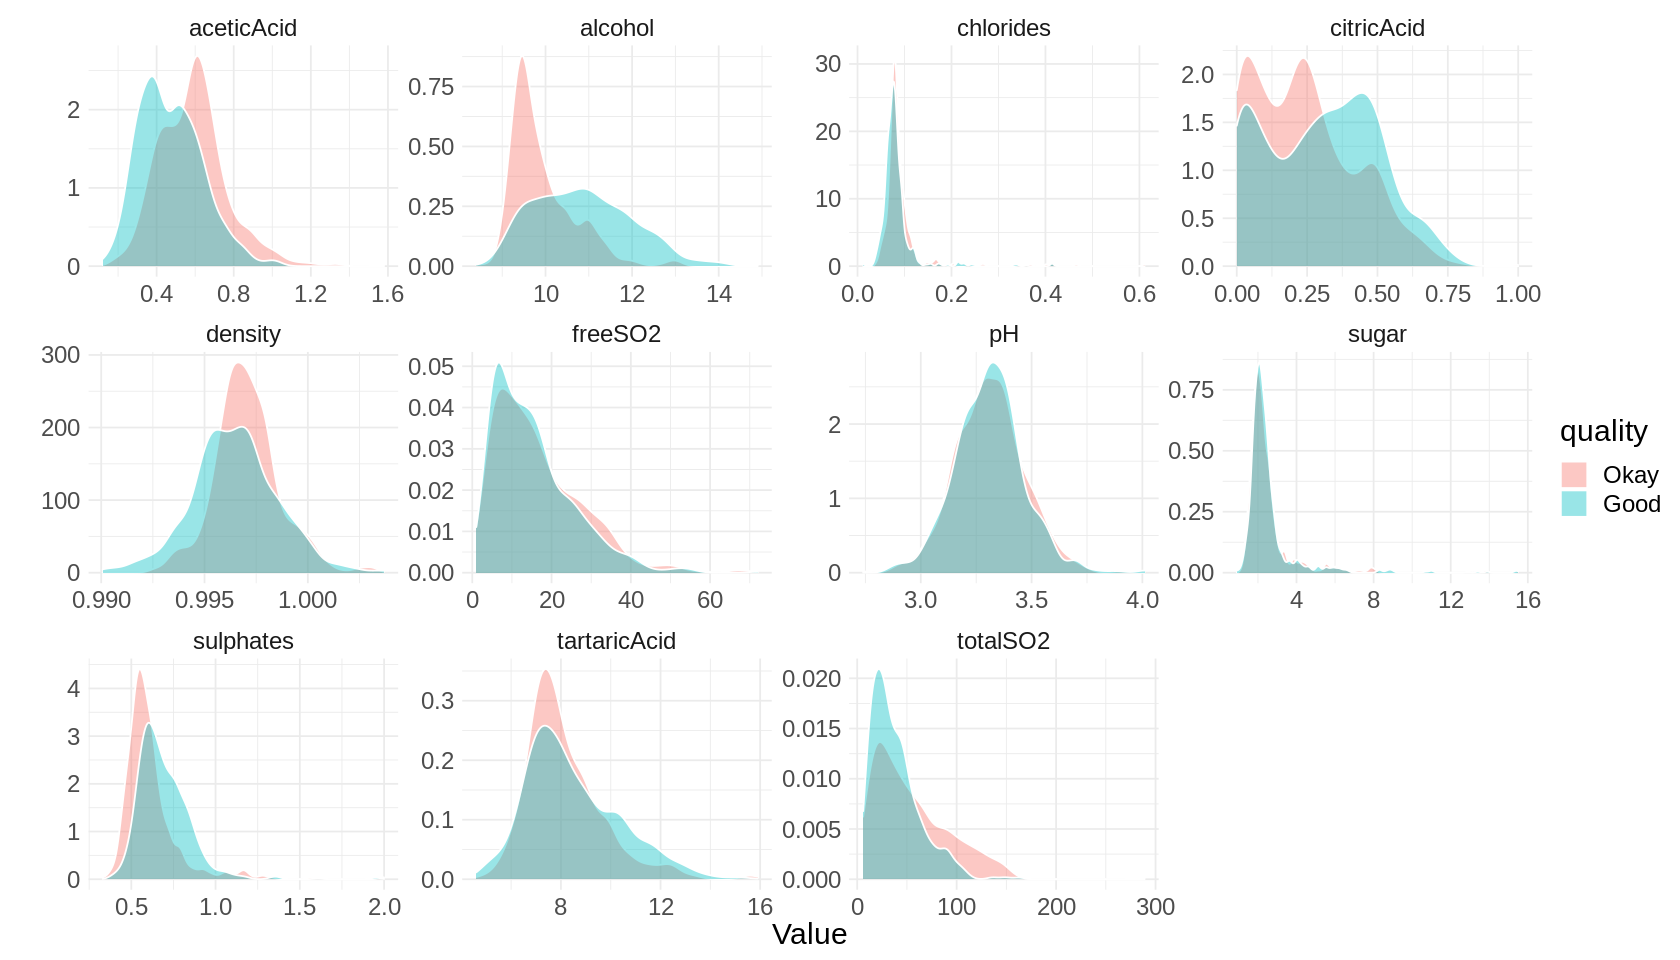

In [3]:
options(repr.plot.width = 14, repr.plot.height = 8)

# Visual analysis of quality distributions (adapted from tutorial_clustering.ipynb, lines 1314-1321)
wine_density_plot <- wine %>%
    pivot_longer(cols = !quality, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = quality)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        labs(x = "Value", y = "") +
        theme(text = element_text(size = 18))
wine_density_plot

##### *Figure 0.2: A density plot of the wine data allowing us to visualize what effect each predictor has on quality.*<br>

#### Pair Plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



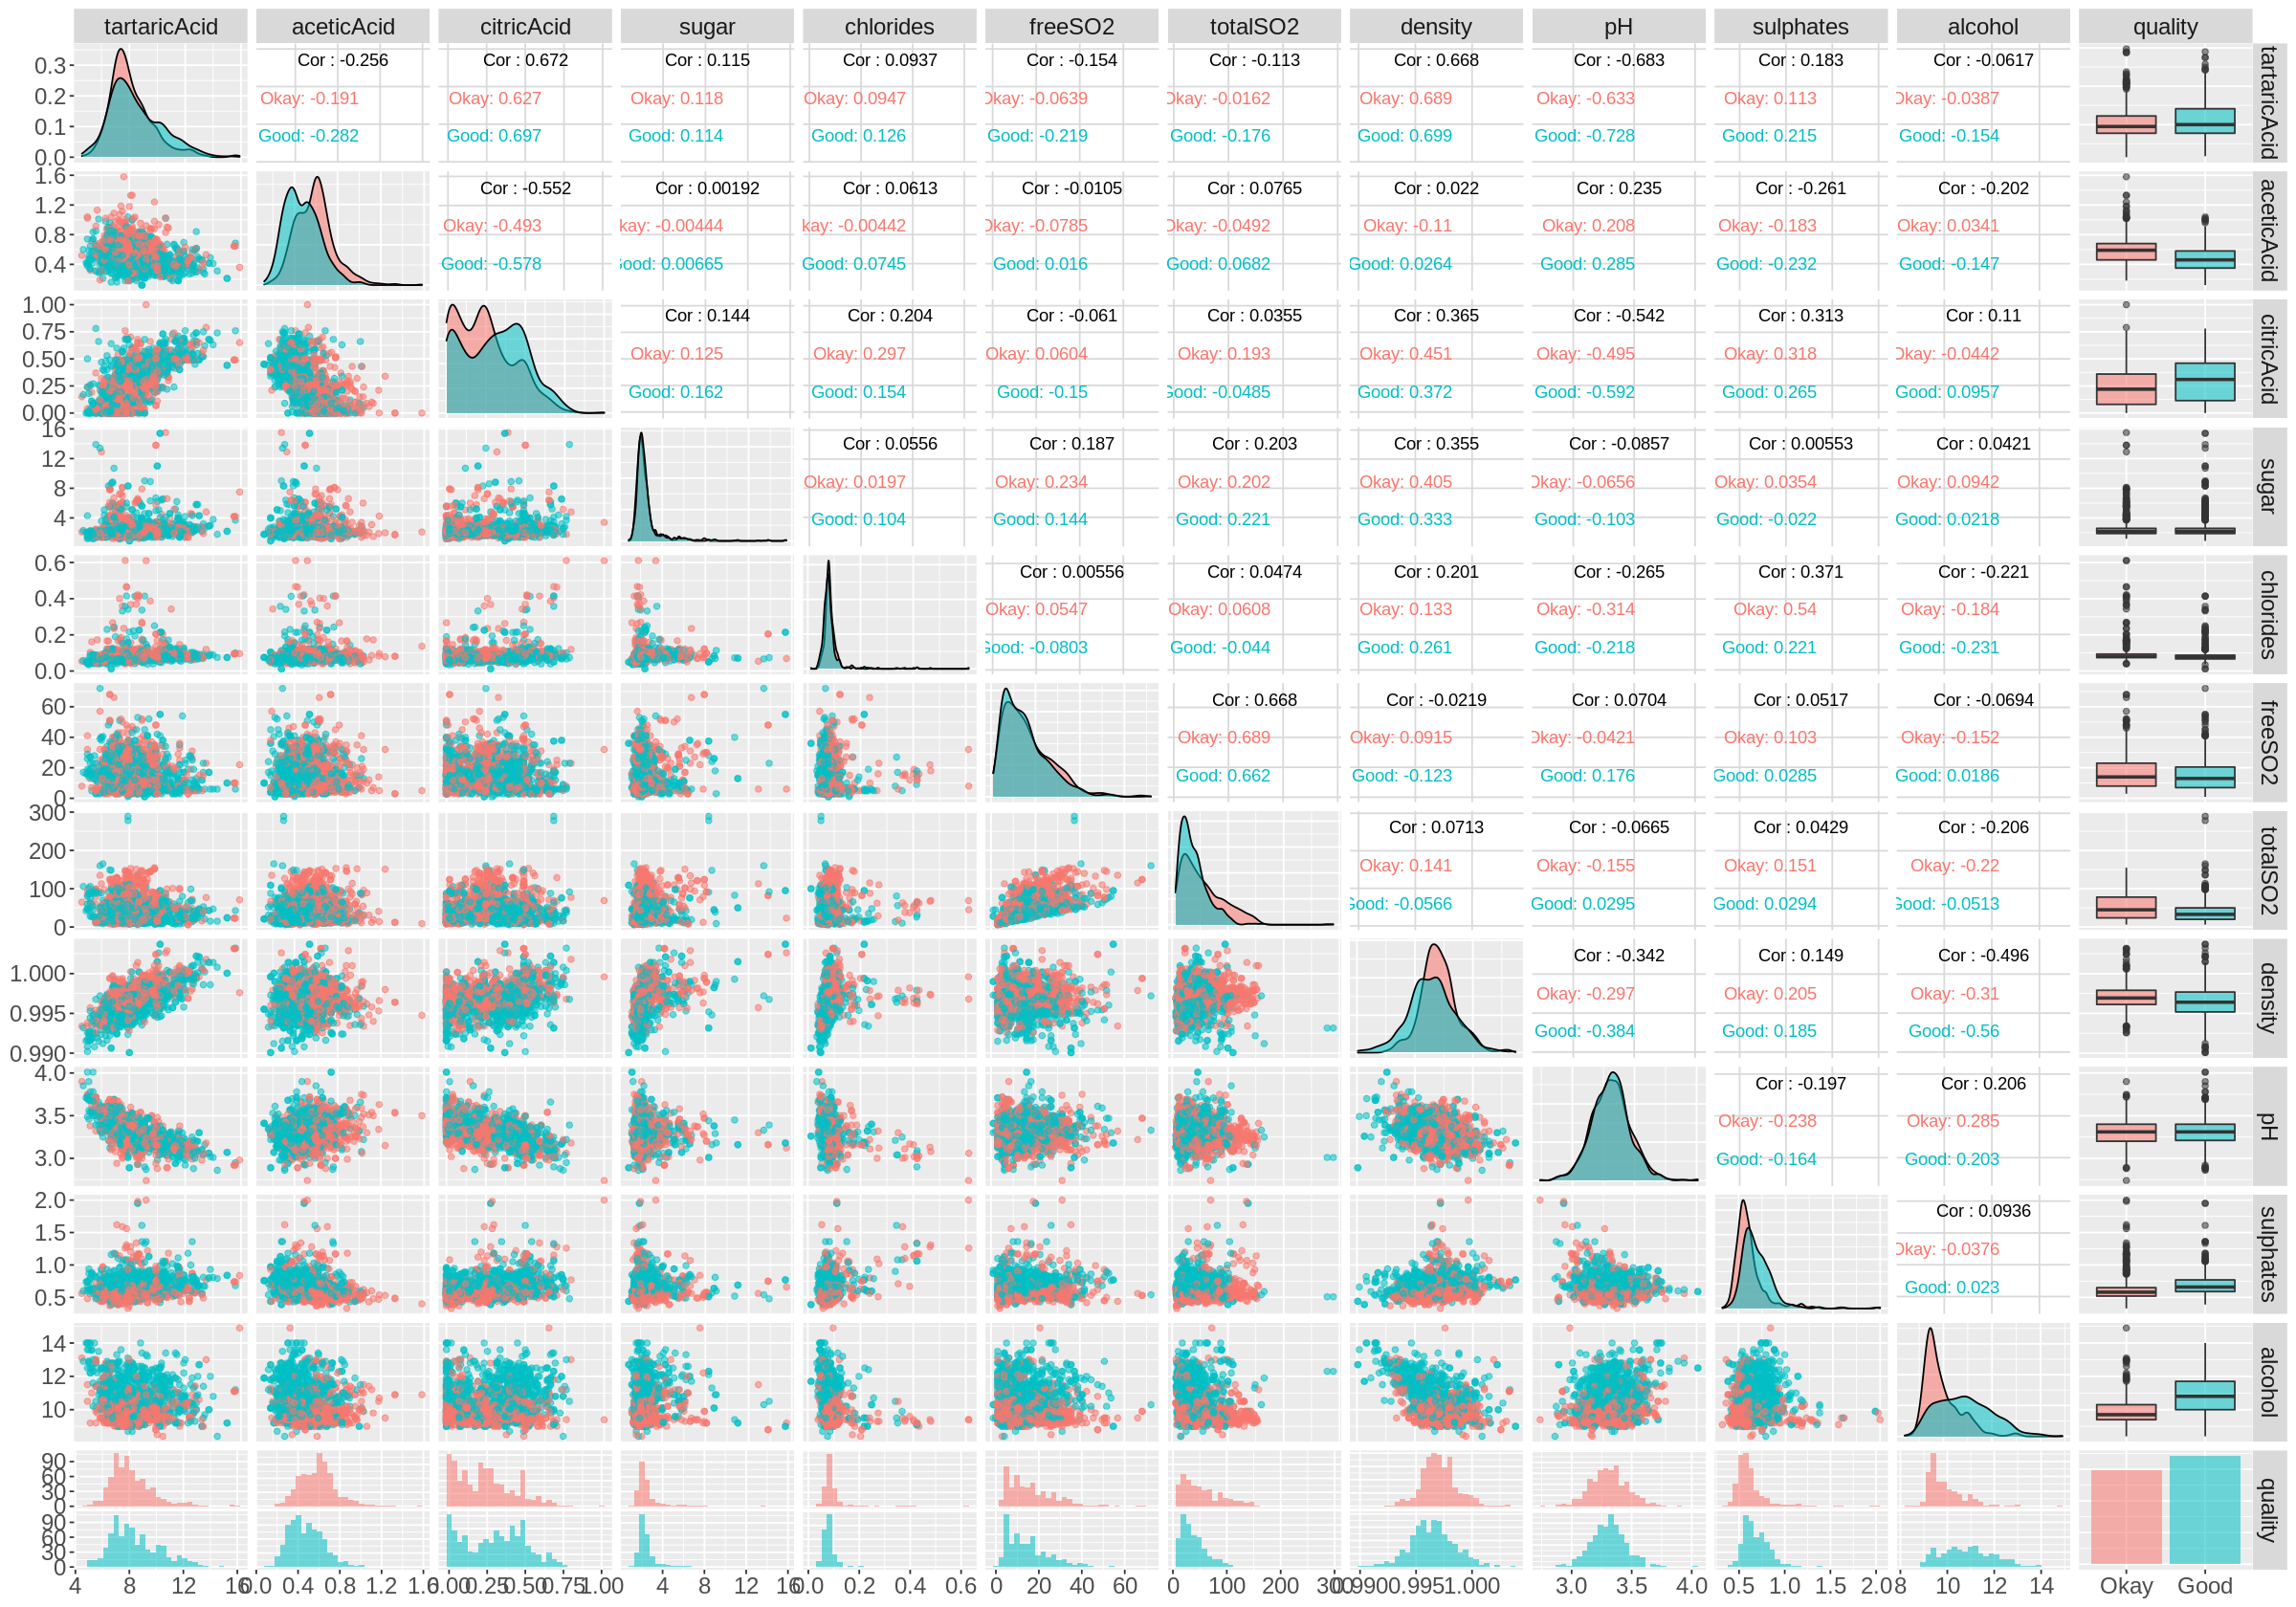

In [4]:
options(repr.plot.width = 20, repr.plot.height = 14)

wine_pair_plot <- wine %>%
    ggpairs(aes(col = quality, alpha = 0.1)) +
    theme(text = element_text(size = 18))
wine_pair_plot

##### *Figure 0.3: A ggpairs plot that helps us further compare the effects of different predictors on quality.*<br>

#### General setup

In [5]:
# Split data into training and testing sets
wine_split = initial_split(wine, prop = 0.75, strata = quality)
wine_train = training(wine_split)
wine_test = testing(wine_split)

# create training splits for cross-validation
wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

# General KNN tuning specification
knn_tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# General tuning grids
gridvals_25 <- tibble(neighbors = seq(from = 1, to = 25))
gridvals_40 <- tibble(neighbors = seq(from = 1, to = 40))

### Classification #1: All variables except `quality` as predictors

For our first classification, we used every variable as a predictor apart from the variable we were predicting, wine quality. We decided to do this since we believed that using every chemical variable would give our classifier a fuller picture of what was favored and unfavored in red wine. This also acted as a base classification which the other classifications could be compared to. 

In [6]:
# recipe with all predictors
wine_all_recipe <- recipe(quality ~ ., data = wine_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wine_all_tuning_workflow <- workflow() %>%
    add_recipe(wine_all_recipe) %>%
    add_model(knn_tuning_spec) 

# get cross-validation metrics
wine_all_tune_metrics <- wine_all_tuning_workflow %>% 
    tune_grid(resamples = wine_vfold, grid = gridvals_25) %>%
    collect_metrics()

In [7]:
# determine best k
wine_all_k_row <- wine_all_tune_metrics %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean)) %>%
    head(1)
wine_all_k_row

wine_all_k <- wine_all_k_row %>%
    pull(neighbors)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7516632,5,0.01042818,Model15


##### *Figure 1.1: A tibble that shows the number of neighbors with the highest accuracy for classification 1.*<br>

In [8]:
# perform knn using wine_all_k
wine_all_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = wine_all_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# train algorithm
wine_all_fit <- workflow() %>%
    add_recipe(wine_all_recipe) %>%
    add_model(wine_all_spec) %>%
    fit(data = wine_train)

# predict testing data w/ algorithm
wine_all_summary <- wine_all_fit %>%
    predict(wine_test) %>%
    bind_cols(wine_test) %>%
    metrics(truth = quality, estimate = .pred_class)
wine_all_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7368421
kap,binary,0.4707220


##### *Figure 1.2: A tibble that shows the accuracy of the model based on the testing data for classification 1.*<br>

### Classification #2: `citricAcid` and `alcohol` as predictors

For our next classification, we used citric acid and alcohol content as predictors. Citric acid is often added to finished wines to reduce ferric haze and increase acidity to produce a more sour flavour (“Citric Acid”). We believed that citric acid was a necessary ingredient to wine, but not one that was needed in high concentrations, and thus would be an important factor in determining wine quality. 

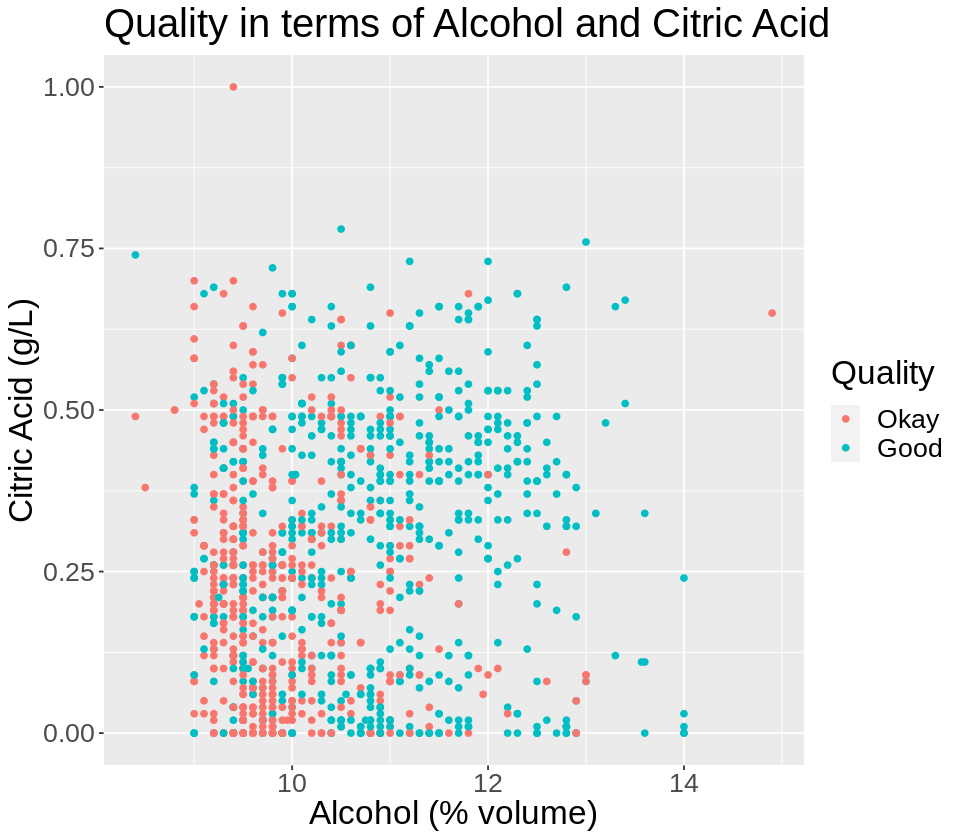

In [9]:
# visualize data
options(repr.plot.width = 8, repr.plot.height = 7)
wine_citric_plot <- wine_train %>%
    select(citricAcid, alcohol, quality) %>%
    ggplot(aes(x = alcohol, y = citricAcid, color = quality)) +
    geom_point() +
    labs(x = "Alcohol (% volume)", y = "Citric Acid (g/L)", color = "Quality") +
    ggtitle("Quality in terms of Alcohol and Citric Acid") +
    theme(text=element_text(size=20))
wine_citric_plot

##### *Figure 2.1: A scatterplot that visualizes the use of citric acid and alcohol in determining quality for the training data.*<br>

In [10]:
# Recipe with citricAcid and alcohol
wine_citric_recipe <- recipe(quality ~ citricAcid + alcohol, data = wine_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wine_citric_tuning_workflow <- workflow() %>%
    add_recipe(wine_citric_recipe) %>%
    add_model(knn_tuning_spec)

# perform cross-validation
wine_citric_tune_metrics <- wine_citric_tuning_workflow %>% 
    tune_grid(resamples = wine_vfold, grid = gridvals_40) %>%
    collect_metrics()

In [11]:
# determine best k
wine_citric_k_row <- wine_citric_tune_metrics %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean)) %>%
    head(1)
wine_citric_k_row

wine_citric_k <- wine_citric_k_row %>%
    pull(neighbors)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
38,accuracy,binary,0.7141696,5,0.00985871,Model38


##### *Figure 2.2: A tibble that shows the number of neighbors with the highest accuracy for classification 2.*<br>

In [12]:
# perform knn using wine_citric_k
wine_citric_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = wine_citric_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# train algorithm
wine_citric_fit <- workflow() %>%
    add_recipe(wine_citric_recipe) %>%
    add_model(wine_citric_spec) %>%
    fit(data = wine_train)

# predict testing data w/ algorithm
wine_citric_summary <- wine_citric_fit %>%
    predict(wine_test) %>%
    bind_cols(wine_test) %>%
    metrics(truth = quality, estimate = .pred_class)
wine_citric_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.716792
kap,binary,0.433872


##### *Figure 2.3: A tibble that shows the accuracy of the model based on the testing data for classification 2.*<br>

### Classification #3: `aceticAcid` and `alcohol` as predictors

For our third classification, acetic acid and alcohol were selected as predictors. Acetic acid is the primary acid associated with the taste and smell of vinegar, often appearing in wine during the fermentation period. It is an ingredient that often causes the wine to lose its fruit flavors, and thus is undesirable in a typical batch of wine. A lower concentration of acetic acid would most likely correlate to a greater quality of red wine. 

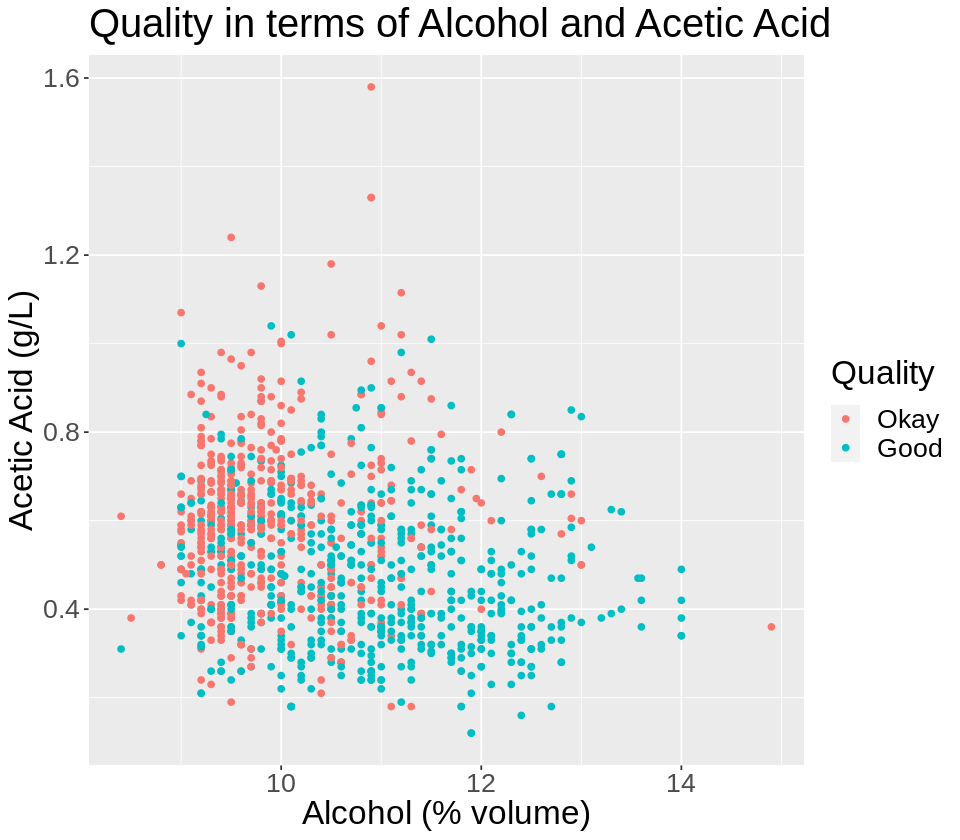

In [13]:
# visualize data
options(repr.plot.width = 8, repr.plot.height = 7)
wine_acetic_plot <- wine_train %>%
    select(aceticAcid, alcohol, quality) %>%
    ggplot(aes(x = alcohol, y = aceticAcid, color = quality)) +
    geom_point() +
    labs(x = "Alcohol (% volume)", y = "Acetic Acid (g/L)", color = "Quality") +
    ggtitle("Quality in terms of Alcohol and Acetic Acid") +
    theme(text=element_text(size=20))
wine_acetic_plot

##### *Figure 3.1: A scatterplot that visualizes the use of acetic acid and alcohol in determining quality for the training data.*<br>

In [14]:
# Recipe with aceticAcid and alcohol
wine_acetic_recipe <- recipe(quality ~ aceticAcid + alcohol, data = wine_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wine_acetic_tuning_workflow <- workflow() %>%
    add_recipe(wine_acetic_recipe) %>%
    add_model(knn_tuning_spec)

# perform cross-validation
wine_acetic_tune_metrics <- wine_acetic_tuning_workflow %>% 
    tune_grid(resamples = wine_vfold, grid = gridvals_40) %>%
    collect_metrics()

In [15]:
# determine best k
wine_acetic_k_row <- wine_acetic_tune_metrics %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean)) %>%
    head(1)
wine_acetic_k_row

wine_acetic_k <- wine_acetic_k_row %>%
    pull(neighbors)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,accuracy,binary,0.7341733,5,0.01053436,Model29


##### *Figure 3.2: A tibble that shows the number of neighbors with the highest accuracy for classification 3.*<br>

In [16]:
# perform knn using wine_acetic_k
wine_acetic_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = wine_acetic_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# train algorithm
wine_acetic_fit <- workflow() %>%
    add_recipe(wine_acetic_recipe) %>%
    add_model(wine_acetic_spec) %>%
    fit(data = wine_train)

# predict testing data w/ algorithm
wine_acetic_summary <- wine_acetic_fit %>%
    predict(wine_test) %>%
    bind_cols(wine_test) %>%
    metrics(truth = quality, estimate = .pred_class)
wine_acetic_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7368421
kap,binary,0.4735949


##### *Figure 3.3: A tibble that shows the accuracy of the model based on the testing data for classification 3.*<br>

### Classification #4: `tartaricAcid` and `alcohol` as predictors

For our final classification, we used tartaric acid and alcohol as predictors. These predictors were chosen because of their similar quality trends in the density plot, and for completeness, since the other two acids in the data set (`citricAcid` and `aceticAcid`) were used in the previous two classifications.

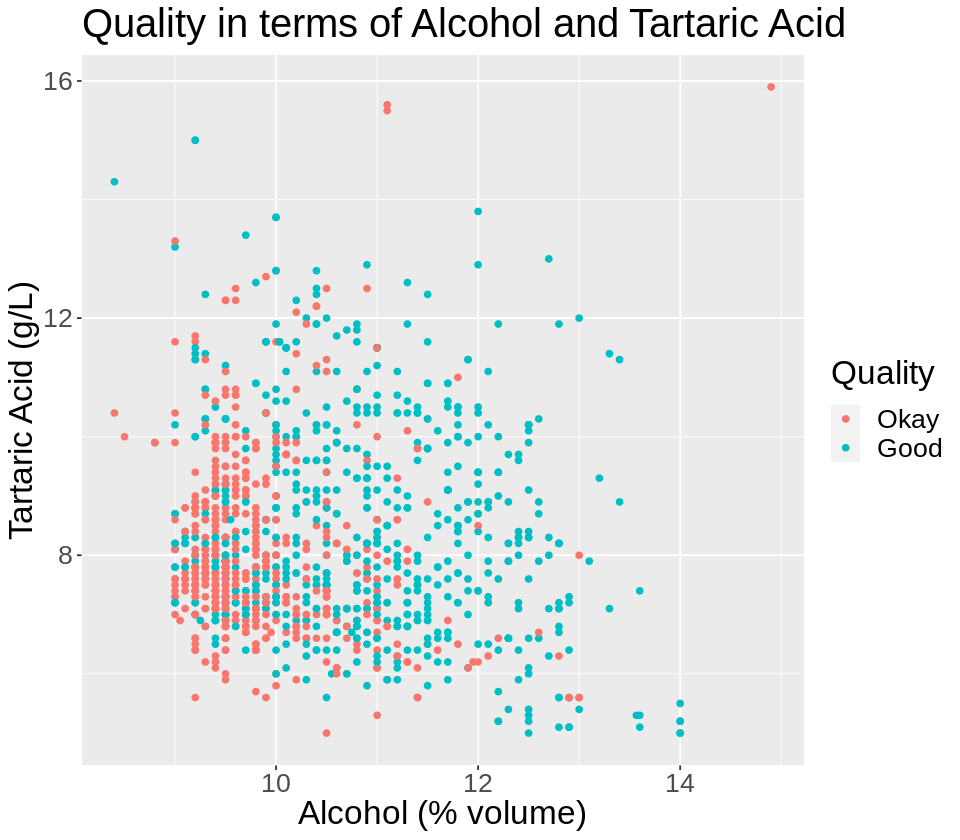

In [17]:
# visualize data
options(repr.plot.width = 8, repr.plot.height = 7)
wine_tartar_plot <- wine_train %>%
    select(tartaricAcid, alcohol, quality) %>%
    ggplot(aes(x = alcohol, y = tartaricAcid, color = quality)) +
    geom_point() +
    labs(x = "Alcohol (% volume)", y = "Tartaric Acid (g/L)", color = "Quality") +
    ggtitle("Quality in terms of Alcohol and Tartaric Acid") +
    theme(text=element_text(size=20))
wine_tartar_plot

##### *Figure 4.1: A scatterplot that visualizes the use of tartaric acid and alcohol in determining quality for the training data.*<br>

In [18]:
# Recipe with tartaricAcid and alcohol
wine_tartar_recipe <- recipe(quality ~ tartaricAcid + alcohol, data = wine_train) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

wine_tartar_tuning_workflow <- workflow() %>%
    add_recipe(wine_tartar_recipe) %>%
    add_model(knn_tuning_spec)

# perform cross-validation
wine_tartar_tune_metrics <- wine_tartar_tuning_workflow %>% 
    tune_grid(resamples = wine_vfold, grid = gridvals_40) %>%
    collect_metrics()

In [19]:
# determine best k
wine_tartar_k_row <- wine_tartar_tune_metrics %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean)) %>%
    head(1)
wine_tartar_k_row

wine_tartar_k <- wine_tartar_k_row %>%
    pull(neighbors)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
40,accuracy,binary,0.7174959,5,0.01665661,Model40


##### *Figure 4.2: The tibble that shows the number of neighbors with the highest accuracy for classification 4.*<br>

In [20]:
# perform knn using wine_tartar_k
wine_tartar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = wine_tartar_k) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# train algorithm
wine_tartar_fit <- workflow() %>%
    add_recipe(wine_tartar_recipe) %>%
    add_model(wine_tartar_spec) %>%
    fit(data = wine_train)

# predict testing data w/ algorithm
wine_tartar_summary <- wine_tartar_fit %>%
    predict(wine_test) %>%
    bind_cols(wine_test) %>%
    metrics(truth = quality, estimate = .pred_class)
wine_tartar_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7243108
kap,binary,0.4479662


##### *Figure 4.3: A tibble that shows the accuracy of the model based on the testing data for classification 4.*<br>

---

## Results

In total, 4 separate classifications were conducted, each of which used a different set of predictor variables in its recipe. 

For our first classification, we used all of our data set’s variables as predictors, and found that 15 neighbors was the most effective k for predicting classifications of our training data. Using this model on our test data returned an accuracy of **73.7%**. Since this was our base classification we had no initial prediction for its accuracy, but we were glad to see that this model was able to correctly predict the quality of a wine roughly every 3 out of 4 times.

From our second classification onward, we began to isolate certain variables to search for patterns within the data that might help us better predict wine quality.<br>
Since we believed that citric acid was necessary in red wine but would become unfavorable in high concentrations, we thought that citric acid would be influential to the quality of red wine. Thus, we used it and the wine’s alcohol content as our predictors for our second classification. Our initial cross validation found that using 38 neighbors produced the most accurate predictions for our training set. Conducting the classification on our testing set using this model returned an accuracy of **71.7%**. This was lower than our first classification, suggesting that there are additional significant predictors to consider other than just citric acid and alcohol content when classifying wine quality.

Our third classification used acetic acid and alcohol as predictors. Since acetic acid is the primary acid associated with the taste and smell of vinegar, we believed that a lower concentration of acetic acid would correspond with a higher quality of wine, and thus would act as an effective predictor. Conducting the classification on our training set, we found that the use of 29 neighbors was most accurate. Using the model on our testing set provided us with an accuracy of **73.7%**, the same value as in our first classification, and greater than the value of our second. This suggested that acetic acid may play a greater role in predicting wine quality than citric acid.

Our final classification utilized tartaric acid and alcohol as predictors. We included tartaric acid as the variable displayed a similar trend to alcohol when plotted against quality. We also included this variable for completeness, predominantly due to the fact we were utilizing the other two acids in our data set for our second and third classifications. Using 40 neighbors, the use of tartaric acid and alcohol as predictors yielded a prediction accuracy of **72.4%**. This value is greater than that of our second classification (which used only citric acid), but does fall lower than the 73.7% accuracy of our other two classifications.

### Further Discussion

Since our first and third classifications produced the best results, we think that acetic acid has the greatest influence on wine quality out of all our predictors (besides alcohol content).

We could use this model to predict the quality of a new red wine using only alcohol and acetic acid content. This would only provide a rough estimate of quality, but could be a useful tool for those trying to make their own red wine at home.

We thought it might be interesting to see our models refined with more advanced code beyond the scope of this course, since that could improve their prediction accuracies.

We also wondered:
- Could our models be adapted to predict the qualities of other types of wines, such as white wines?<br>
- Would the introduction of other non-chemical factors, such as fermentation time or grape variety, improve our classifier?

---

## Works Cited

- Bhattacharjee, Sandeep. “An analysis of classification techniques in data mining for determining quality of wine product: red & white.” *Amity University*, 2016. [www.researchgate.net/publication/304180279](https://www.researchgate.net/publication/304180279)
- “Citric Acid.” *University of California*, [wineserver.ucdavis.edu/industry-info/enology/methods-and-techniques/common-chemical-reagents/citric-acid](https://wineserver.ucdavis.edu/industry-info/enology/methods-and-techniques/common-chemical-reagents/citric-acid). Accessed 08 April 2022.
- Nuriel S. M. et al. “Wine Quality and Type Prediction from Physicochemical Properties Using Neural Networks for Machine Learning: A Free Software for Winemakers and Customers.” *Darca and Bnei Akiva Schools, Israel*, 2022.
- P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. “Modeling wine preferences by data mining from physicochemical properties.” *Decision Support Systems, Elsevier, 47(4)*, pp. 547-553, 2009. [doi.org/10.1016/j.dss.2009.05.016](https://doi.org/10.1016/j.dss.2009.05.016) 
- tutorial_clustering.ipynb. *dsci-100-student*, commit d6b5378f841b4257132a5bb81f4f95f66a9684c8, DSCI 100: Introduction to Data Science & Tiffany Timbers, 2018. *GitHub*, [github.com/UBC-DSCI/dsci-100-student/blob/master/materials/tutorial_clustering/tutorial_clustering.ipynb](https://github.com/UBC-DSCI/dsci-100-student/blob/master/materials/tutorial_clustering/tutorial_clustering.ipynb).